In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from findCorrespondance import findCorrespondance
from IPython.core.debugger import Tracer
from GetInliersRANSAC import GetInliersRANSAC
from ExtractCameraPose import ExtractCameraPose
from DrawCorrespondence import DrawCorrespondence
from EssentialMatrixFromFundamentalMatrix import EssentialMatrixFromFundamentalMatrix
from LinearTriangulation import LinearTriangulation
from DisambiguateCameraPose import DisambiguateCameraPose
from NonLinearTriangulation import *

%matplotlib inline


#### Reject Outliers and Estimate Fundamental Matrix

In [2]:
Show_correspondence = True

all_Fs = []
all_inliers = []

n_images = 6
Mx = []
My = []
M =[]
for i in range(1, n_images):
    mx = []
    my = []
    m =[]
    for j in range(i+1, n_images + 1):

        x_list,y_list,binary_list,rgb_list = findCorrespondance(i, j)

        if(j==i+1):
            mx = x_list
            my = y_list
            m = binary_list
        else:
            mx = np.hstack((mx,x_list[:,1].reshape((-1,1))))
            my = np.hstack((my,y_list[:,1].reshape((-1,1))))
            m = np.hstack((m,binary_list[:,1].reshape((-1,1))))
         
    if(i==1):
        Mx = mx
        My = my
        M = m
    else:   
        
        mx = np.hstack((np.zeros((mx.shape[0],i-1)),mx))
        my = np.hstack((np.zeros((my.shape[0],i-1)),my))
        m = np.hstack((np.zeros((m.shape[0],i-1)),m))
        assert Mx.shape[1]==mx.shape[1],"SHape not matched"
        Mx = np.vstack((Mx,mx))
        assert My.shape[1]==my.shape[1],"Shape My not matched"
        My = np.vstack((My,my))
        M = np.vstack((M,m))  

('Final F = ', array([[-3.33671007e-07, -1.01701703e-05,  2.59762918e-03],
       [ 1.25181992e-05, -6.40688524e-07, -4.48753625e-03],
       [-4.21195542e-03,  2.31182016e-03,  1.00000000e+00]]))
[[-0.02096797 -0.73650712 -0.31387968]
 [ 0.8927321  -0.04768101  0.40752572]
 [ 0.19731078 -0.57761877 -0.14387801]]
('E svd U', array([[-0.02292791, -0.80054803, -0.59882982],
       [ 0.97617852,  0.11134083, -0.18622221],
       [ 0.21575403, -0.5888345 ,  0.77892498]]))
('E svd S', array([1.00000000e+00, 1.00000000e+00, 4.26692152e-17]))
('E svd U[:, 2]', array([-0.59882982, -0.18622221,  0.77892498]))
('Final F = ', array([[ 3.81832759e-07, -6.64547527e-06,  1.25699190e-03],
       [ 8.22918644e-06,  7.04964233e-07, -6.28126378e-03],
       [-2.93669457e-03,  5.10304572e-03,  1.00000000e+00]]))
[[ 0.06734244 -0.87987841 -0.39245444]
 [ 0.95352524  0.06000187 -0.14199055]
 [ 0.24655167  0.26194581  0.06988009]]
('E svd U', array([[ 0.96337324, -0.06821667,  0.25934241],
       [ 0.001300

UnboundLocalError: local variable 'X' referenced before assignment

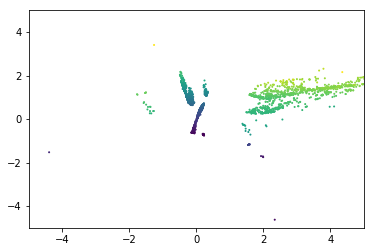

In [3]:
img1 = 1
img2 = 4

for i in range(1, n_images):
    for j in range(i+1, n_images + 1):
    
        img1 = i
        img2 = j

        output = np.logical_and(M[:, img1-1], M[:, img2-1])
        indices, = np.where(output == True)
        pts1 = np.hstack((Mx[indices,img1-1].reshape((-1,1)),My[indices,img1-1].reshape((-1,1))))
        pts2 = np.hstack((Mx[indices,img2-1].reshape((-1,1)),My[indices,img2-1].reshape((-1,1))))
        best_F, inliers_a, inliers_b = GetInliersRANSAC(np.int32(pts1), np.int32(pts2))
        # finalF, inliers = GetInliersRANSAC(correspondence_list, elimination_threshold)
        print("Final F = ", best_F)
        all_Fs.append(best_F)
        all_inliers.append(np.hstack((inliers_a, inliers_b)))

        if Show_correspondence is False:
            out = DrawCorrespondence(img1, img2, inliers_a, inliers_b)

            cv2.imshow("img3", out)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

        
        K = np.array([[568.996140852,0,643.21055941],
             [0, 568.988362396, 477.982801038],
             [0, 0, 1]])
        E = EssentialMatrixFromFundamentalMatrix(best_F,K)
        print(E)
        R_set,C_set = ExtractCameraPose(E,K)



        X = []
        for n in range(0,4):
            X.append(LinearTriangulation(K,np.zeros((3,1)),np.identity(3),C_set[n].T,R_set[n],np.int32(pts1),np.int32(pts2)))


        X_new, R, C = DisambiguateCameraPose(C_set, R_set, X)
        X_new


        plt.scatter(X_new[:,0], X_new[:,2], c=X_new[:,2], cmap='viridis',s = 1);  #viridis
        # plt.set_xlabel('x')
        # ax.set_ylabel('y')
        # plt.set_ylabel('z');
        axes = plt.gca()
        axes.set_xlim([-5,5])
        axes.set_ylim([-5,5])

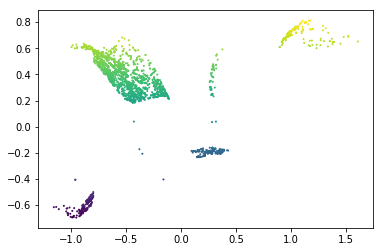

In [45]:
plt.scatter(X_new[:,0], X_new[:,2], c=X_new[:,2], cmap='viridis',s = 1);  #viridis
# plt.set_xlabel('x')
# ax.set_ylabel('y')
# plt.set_ylabel('z');
axes = plt.gca()
# axes.set_xlim([-1,1])
# axes.set_ylim([-2,2])

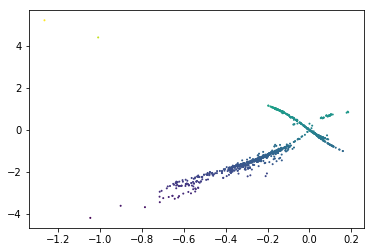

In [53]:
plt.scatter(X_new[:,0], X_new[:,1], c=X_new[:,1], cmap='viridis',s = 1);  #viridis
# plt.set_xlabel('x')
# ax.set_ylabel('y')
# plt.set_ylabel('z');
axes = plt.gca()
# axes.set_xlim([-1,1])
# axes.set_ylim([-2,2])